In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from time_series_preprocessing import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
AAPL = pd.read_csv("../../Stock-Price-Prediction/data/dataset/APPL.csv")
AAPL["Date"] = pd.to_datetime(AAPL["Date"])
AAPL.set_index("Date", inplace=True)

In [3]:
AAPL

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.845036,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.075386,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.530045,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.450966,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.126766,164101200
...,...,...,...,...,...,...
2024-04-08,169.029999,169.199997,168.240005,168.449997,168.449997,37425500
2024-04-09,168.699997,170.080002,168.350006,169.669998,169.669998,42451200
2024-04-10,168.800003,169.089996,167.110001,167.779999,167.779999,49709300


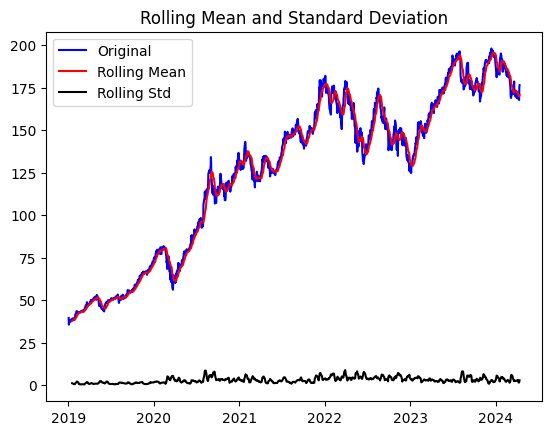

Results of Dickey-Fuller Test:
Test Statistics                  -1.530651
p-value                           0.518298
No. of Lags Used                  0.000000
Number of Observations Used    1328.000000
Critical Value (1%)              -3.435284
Critical Value (5%)              -2.863719
Critical Value (10%)             -2.567930
dtype: float64


In [4]:
df_close = AAPL['Close']    
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

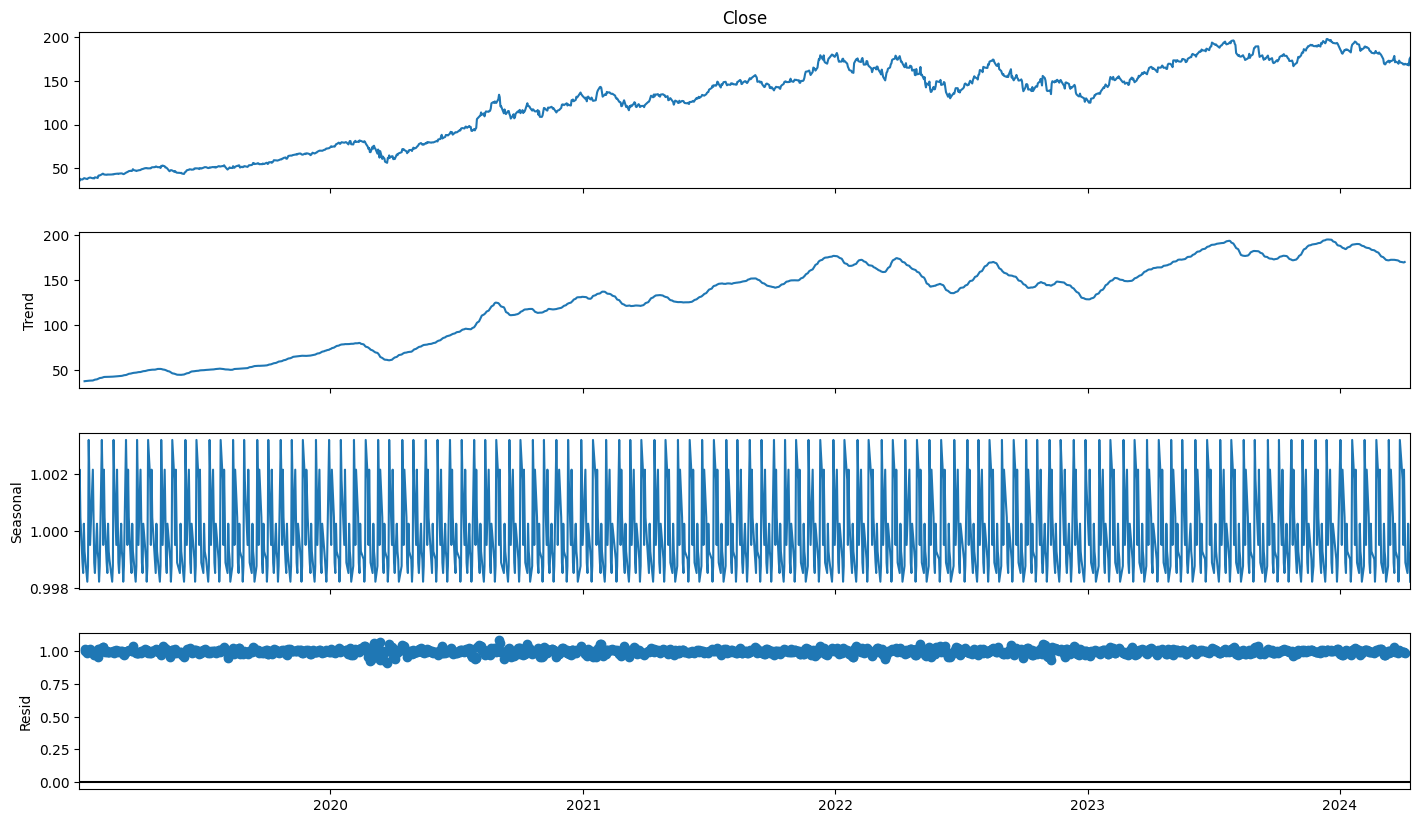

In [5]:
decompose_seasonality(df_close)

In [6]:
# Eliminate trend
df_log, detrended_series, moving_avg, std_dev = eliminate_trend(df_close)

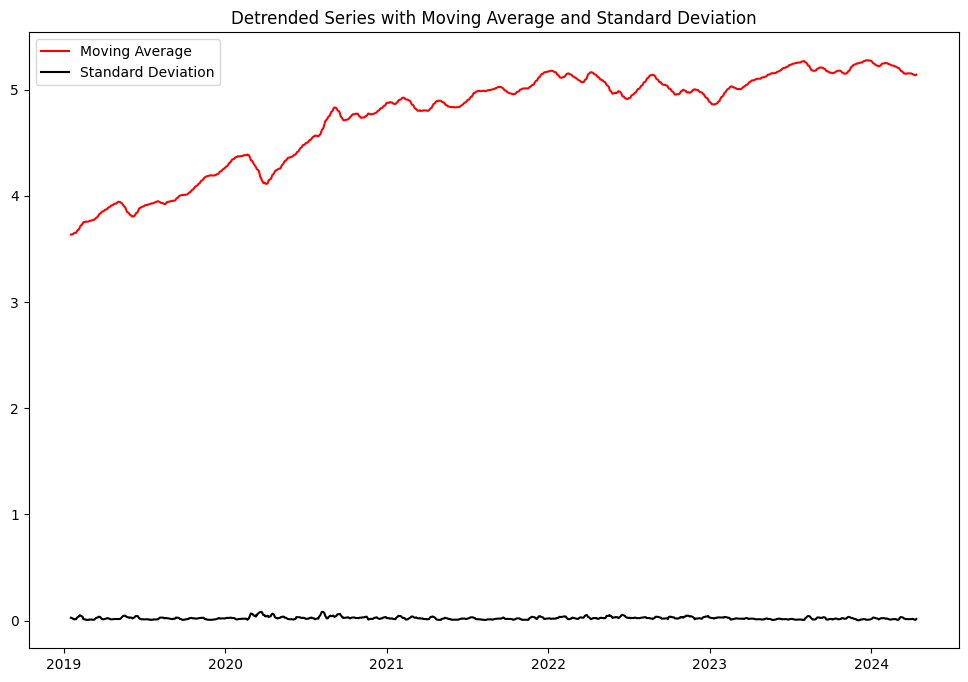

In [7]:
plt.figure(figsize=(12, 8))  
plt.plot(moving_avg, color="red", label="Moving Average")
plt.plot(std_dev, color="black", label="Standard Deviation")
plt.legend()
plt.title("Detrended Series with Moving Average and Standard Deviation")
plt.show()

Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression

def LIN_REG_ALGO(df):
    # Number of days to be forecasted in the future
    forecast_out = 7
    
    # Price after n days
    df['Close after n days'] = df['Close'].shift(-forecast_out)
    
    # New DataFrame with only relevant data
    df_new = df[['Close', 'Close after n days']]

    # Structure data for training, testing, and forecasting
    # Labels of known data, discard last 7 rows
    y = np.array(df_new.iloc[:-forecast_out, -1])
    y = np.reshape(y, (-1, 1))
    
    # All columns of known data except labels, discard last 7 rows
    X = np.array(df_new.iloc[:-forecast_out, 0:-1])
    
    # Unknown, X to be forecasted
    X_to_be_forecasted = np.array(df_new.iloc[-forecast_out:, 0:-1])

    # Training, testing to plot graphs and check accuracy
    X_train = X[0:int(0.8 * len(df)), :]
    X_test = X[int(0.8 * len(df)) - forecast_out:-forecast_out, :]
    y_train = y[0:int(0.8 * len(df)), :]
    y_test = y[int(0.8 * len(df)) - forecast_out:-forecast_out, :]

    # Feature Scaling (Normalization)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_to_be_forecasted = sc.transform(X_to_be_forecasted)

    # Training
    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)

    # Testing
    y_test_pred = clf.predict(X_test)
    y_test_pred = y_test_pred * (1.04)  # Adjust for prediction error
    
    # Plotting
    fig = plt.figure(figsize=(7.2, 4.8), dpi=65)
    plt.plot(df.index[-len(y_test):], y_test, label='Actual Price') 
    plt.plot(df.index[-len(y_test):], y_test_pred, label='Predicted Price') 
    plt.title('Stock Price Prediction using Linear Regression')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend(loc=4)
    plt.show()

    # Calculate RMSE
    error_lr = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Forecasting
    forecast_set = clf.predict(X_to_be_forecasted)
    forecast_set = forecast_set * (1.04)  # Adjust for prediction error
    mean = forecast_set.mean()
    lr_pred = forecast_set[0, 0]
    
    print()
    print("------")
    # Get the last predicted closing price from the Linear Regression model
    lr_pred = forecast_set[-1]

    # Get the date of the last prediction
    last_date_lr = df.index[-1]  # Assuming the last prediction corresponds to the last date in the dataset

    # Print the prediction for the next day by Linear Regression
    print(f"Closing Price Prediction by Linear Regression ({last_date_lr}):", lr_pred)
    print("Linear Regression RMSE:", error_lr)
    print("------")
    
    return df, lr_pred, forecast_set, mean, error_lr

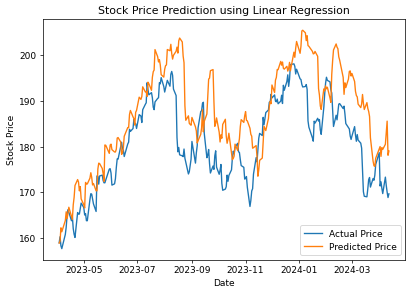


------
Closing Price Prediction by Linear Regression (2024-04-12 00:00:00): [183.40053256]
Linear Regression RMSE: 9.079228059454989
------


(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-01-02   38.722500   39.712502   38.557499   39.480000   37.845036   
 2019-01-03   35.994999   36.430000   35.500000   35.547501   34.075386   
 2019-01-04   36.132500   37.137501   35.950001   37.064999   35.530045   
 2019-01-07   37.174999   37.207500   36.474998   36.982498   35.450966   
 2019-01-08   37.389999   37.955002   37.130001   37.687500   36.126766   
 ...                ...         ...         ...         ...         ...   
 2024-04-08  169.029999  169.199997  168.240005  168.449997  168.449997   
 2024-04-09  168.699997  170.080002  168.350006  169.669998  169.669998   
 2024-04-10  168.800003  169.089996  167.110001  167.779999  167.779999   
 2024-04-11  168.339996  175.460007  168.160004  175.039993  175.039993   
 2024-04-12  174.259995  178.360001  174.210007  176.550003  176.550003   
 
                Volume 

In [9]:
LIN_REG_ALGO(AAPL)

KNN

In [10]:
from sklearn.neighbors import KNeighborsRegressor

def KNN_ALGO(df):
    # Number of days to be forecasted in the future
    forecast_out = 7
    
    # Price after n days
    df['Close after n days'] = df['Close'].shift(-forecast_out)
    
    # New DataFrame with only relevant data
    df_new = df[['Close', 'Close after n days']]

    # Structure data for training, testing, and forecasting
    # Labels of known data, discard last 7 rows
    y = np.array(df_new.iloc[:-forecast_out, -1])
    y = np.reshape(y, (-1, 1))
    
    # All columns of known data except labels, discard last 7 rows
    X = np.array(df_new.iloc[:-forecast_out, 0:-1])
    
    # Unknown, X to be forecasted
    X_to_be_forecasted = np.array(df_new.iloc[-forecast_out:, 0:-1])

    # Training, testing to plot graphs and check accuracy
    X_train = X[0:int(0.8 * len(df)), :]
    X_test = X[int(0.8 * len(df)) - forecast_out:-forecast_out, :]
    y_train = y[0:int(0.8 * len(df)), :]
    y_test = y[int(0.8 * len(df)) - forecast_out:-forecast_out, :]

    # Feature Scaling (Normalization)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_to_be_forecasted = sc.transform(X_to_be_forecasted)

    # Training
    knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto')
    knn.fit(X_train, y_train)

    # Testing
    y_test_pred = knn.predict(X_test)
    y_test_pred = y_test_pred * (1.04)  # Adjust for prediction error
    
    # Plotting
    fig = plt.figure(figsize=(7.2, 4.8), dpi=65)
    plt.plot(df.index[-len(y_test):], y_test, label='Actual Price')  
    plt.plot(df.index[-len(y_test):], y_test_pred, label='Predicted Price')  
    plt.title('Stock Price Prediction using KNN Regression')
    plt.xlabel('Date')  
    plt.ylabel('Stock Price')
    plt.legend(loc=4)
    plt.show()

    # Calculate RMSE
    error_knn = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Forecasting
    forecast_set = knn.predict(X_to_be_forecasted)
    forecast_set = forecast_set * (1.04)  # Adjust for prediction error
    mean = forecast_set.mean()
    knn_pred = forecast_set[0, 0]
    
    print()
    print("------")
    # Get the last predicted closing price from the KNN model
    knn_pred = forecast_set[-1]

    # Get the date of the last prediction
    last_date_knn = df.index[-1]  # Assuming the last prediction corresponds to the last date in the dataset

    # Print the prediction for the next day by KNN
    print(f"Closing Price Prediction by KNN Regression ({last_date_knn}):", knn_pred)
    print("KNN Regression RMSE:", error_knn)
    print("------")
    
    return df, knn_pred, forecast_set, mean, error_knn

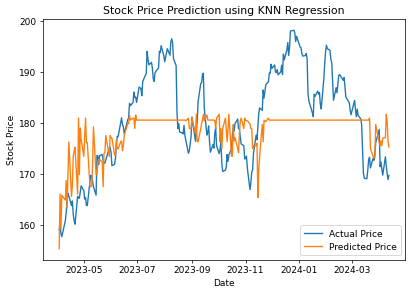


------
Closing Price Prediction by KNN Regression (2024-04-12 00:00:00): [181.6443186]
KNN Regression RMSE: 8.095921112501868
------


(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-01-02   38.722500   39.712502   38.557499   39.480000   37.845036   
 2019-01-03   35.994999   36.430000   35.500000   35.547501   34.075386   
 2019-01-04   36.132500   37.137501   35.950001   37.064999   35.530045   
 2019-01-07   37.174999   37.207500   36.474998   36.982498   35.450966   
 2019-01-08   37.389999   37.955002   37.130001   37.687500   36.126766   
 ...                ...         ...         ...         ...         ...   
 2024-04-08  169.029999  169.199997  168.240005  168.449997  168.449997   
 2024-04-09  168.699997  170.080002  168.350006  169.669998  169.669998   
 2024-04-10  168.800003  169.089996  167.110001  167.779999  167.779999   
 2024-04-11  168.339996  175.460007  168.160004  175.039993  175.039993   
 2024-04-12  174.259995  178.360001  174.210007  176.550003  176.550003   
 
                Volume 

In [11]:
KNN_ALGO(AAPL)

SVM

In [12]:
from sklearn.svm import SVR

def SVM_ALGO(df):
    # Number of days to be forecasted in the future
    forecast_out = 7
    
    # Price after n days
    df['Close after n days'] = df['Close'].shift(-forecast_out)
    
    # New DataFrame with only relevant data
    df_new = df[['Close', 'Close after n days']]

    # Structure data for training, testing, and forecasting
    # Labels of known data, discard last 7 rows
    y = np.array(df_new.iloc[:-forecast_out, -1])
    y = np.reshape(y, (-1, 1))
    
    # All columns of known data except labels, discard last 7 rows
    X = np.array(df_new.iloc[:-forecast_out, 0:-1])
    
    # Unknown, X to be forecasted
    X_to_be_forecasted = np.array(df_new.iloc[-forecast_out:, 0:-1])

    # Training, testing to plot graphs and check accuracy
    X_train = X[0:int(0.8 * len(df)), :]
    X_test = X[int(0.8 * len(df)) - forecast_out:-forecast_out, :]
    y_train = y[0:int(0.8 * len(df)), :]
    y_test = y[int(0.8 * len(df)) - forecast_out:-forecast_out, :]

    # Feature Scaling (Normalization)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_to_be_forecasted = sc.transform(X_to_be_forecasted)

    # Training
    svm = SVR(kernel='linear')
    svm.fit(X_train, y_train)

    # Testing
    y_test_pred = svm.predict(X_test)
    y_test_pred = y_test_pred * (1.04)  # Adjust for prediction error
    
    # Plotting
    fig = plt.figure(figsize=(7.2, 4.8), dpi=65)
    plt.plot(df.index[-len(y_test):], y_test, label='Actual Price')  
    plt.plot(df.index[-len(y_test):], y_test_pred, label='Predicted Price')  
    plt.title('Stock Price Prediction using SVM Regression')
    plt.xlabel('Date')  
    plt.ylabel('Stock Price')
    plt.legend(loc=4)
    plt.show()

    # Calculate RMSE
    error_svm = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Forecasting
    forecast_set = svm.predict(X_to_be_forecasted)
    forecast_set = forecast_set * (1.04)  # Adjust for prediction error
    mean = forecast_set.mean()
    svm_pred = forecast_set[0]  # Corrected indexing
    
    print()
    print("------")
    # Get the last predicted closing price from the SVM model
    svm_pred = forecast_set[-1]

    # Get the date of the last prediction
    last_date_svm = df.index[-1]  # Assuming the last prediction corresponds to the last date in the dataset

    # Print the prediction for the next day by SVM
    print(f"Closing Price Prediction by SVM Regression ({last_date_svm}):", svm_pred)
    print("SVM Regression RMSE:", error_svm)
    print("------")
    
    return df, svm_pred, forecast_set, mean, error_svm

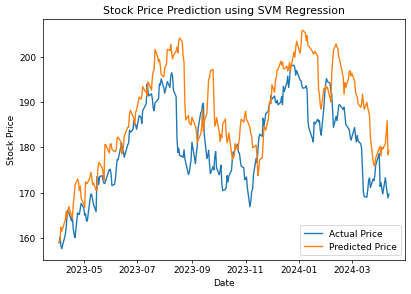


------
Closing Price Prediction by SVM Regression (2024-04-12 00:00:00): 183.67008679911828
SVM Regression RMSE: 9.296955538434759
------


(                  Open        High         Low       Close   Adj Close  \
 Date                                                                     
 2019-01-02   38.722500   39.712502   38.557499   39.480000   37.845036   
 2019-01-03   35.994999   36.430000   35.500000   35.547501   34.075386   
 2019-01-04   36.132500   37.137501   35.950001   37.064999   35.530045   
 2019-01-07   37.174999   37.207500   36.474998   36.982498   35.450966   
 2019-01-08   37.389999   37.955002   37.130001   37.687500   36.126766   
 ...                ...         ...         ...         ...         ...   
 2024-04-08  169.029999  169.199997  168.240005  168.449997  168.449997   
 2024-04-09  168.699997  170.080002  168.350006  169.669998  169.669998   
 2024-04-10  168.800003  169.089996  167.110001  167.779999  167.779999   
 2024-04-11  168.339996  175.460007  168.160004  175.039993  175.039993   
 2024-04-12  174.259995  178.360001  174.210007  176.550003  176.550003   
 
                Volume 

In [13]:
SVM_ALGO(AAPL)